<a href="https://colab.research.google.com/github/prananto/baud.prananto/blob/main/Face_Recognition_with_VGGFace2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instalasi Modul**

In [31]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
#!pip install keras_vggface
!pip install Keras-Applications
!pip install mtcnn

filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))



  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-035ei40v
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-035ei40v


20951

**Pengolahan Foto untuk Ekstraksi Fitur Wajah**

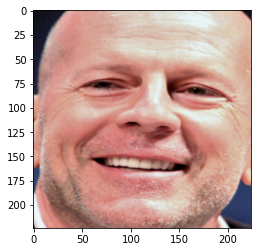

In [35]:
# example of face detection with mtcnn
import mtcnn
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load the photo and extract the face
pixels = extract_face('/content/sample_data/bruce_willis1.jpg')
# plot the extracted face
pyplot.imshow(pixels)
# show the plot
pyplot.show()

**Identifikasi Wajah berdasarkan database resnet50**

In [36]:
# Example of face detection with a vggface2 model
import keras_vggface
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load the photo and extract the face
pixels = extract_face('/content/sample_data/bruce_willis1.jpg')
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)
# create a vggface model
model = VGGFace(model='resnet50')
# perform prediction
yhat = model.predict(samples)
# convert prediction into names
results = decode_predictions(yhat)
# display most likely results
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))

b' Bruce_Willis': 98.933%
b' Krister_Henriksson': 0.166%
b' Florent_Balmont': 0.063%
b' Andreas_Dresen': 0.047%
b' Michael_Chiklis': 0.031%


**Verifikasi Wajah**

In [37]:
# face verification with the VGGFace2 model
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

# define filenames
filenames = ['/content/sample_data/bruce_willis1.jpg', '/content/sample_data/bruce_willis2.jpg',
	'/content/sample_data/bruce_willis3.jpg', '/content/sample_data/channing_tatum.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define sharon stone
sharon_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests, 2 Photos of Bruce Willis')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests, Photo of Channing Tatum')
is_match(embeddings[0], embeddings[3])

Positive Tests, 2 Photos of Bruce Willis
>face is a Match (0.357 <= 0.500)
>face is a Match (0.355 <= 0.500)
Negative Tests, Photo of Channing Tatum
>face is NOT a Match (0.695 > 0.500)
